# Test MMC forcing

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC
import postproamrwindsample_xarray as ppsamplexr

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import CubicSpline

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
# Location of precursor run with boundary data
precursordir  = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/PrecursorLayout/MMC_BM1_BigPrecursor/'
precursorsetup= precursordir+'/abl_MMC_Precursor.inp'

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [4]:
#case.setAMRWindInput('time_control', ['const dt'])
case.setAMRWindInput('time.fixed_dt',  0.10)

In [5]:
# Set the restart point
chkdir = precursordir+'/chk48000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [6]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics00000.nc'
forcingdict = {'ablstatfile':ablstatfile, 'tendencyforcing_file':'./tendencyforcing.nc'}
inflowplanes= ['xhi', 'ylo'] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_file/'

In [7]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           autoset_BodyForcing=False,
                           autoset_MMCForcing=False,
                           autoset_MMCTendencyForcing=True,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/PrecursorLayout/MMC_BM1_BigPrecursor//bndry_file/'
SET ABL_bndry_planes = ['ylo', 'xhi']
SET is_periodicx = False
SET is_periodicy = False
SET xhi_type = 'mass_inflow'
SET xhi_density = 1.103707
SET xhi_temperature = 0.0
SET xhi_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.103707
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xlo_type = 'pressure_outflow'
SET xlo_density = None
SET xlo_temperature = None
SET xlo_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET ABLForcing = False
Wrote ./tendencyforcing.nc
SET ABL_tendency_forcing = True
SET ABL_mesoscale_forcing = './tendencyforcing.nc'
SET ABLMesoForcingMom = True
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 48000


## Add refinements

In [8]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,     13800,    15000,      18500,  100,  250,      center:farm units:meter
# KP
0,     6000,    6000,      9300,  100,  350, center:specified units:meter centerx:639000 centery:4029000 centerz:100 orientation:180
# AF
0,     8000,    8000,      8000,  100,  350, center:specified units:meter centerx:628000 centery:4017500 centerz:100 orientation:180

# Turbine refinement
#1,     0.6,    0.6,     0.6,    0.525, 0.525, orientation:nacdir
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [9]:
case.refine_createAllZones()

(615288.0, 654712.0, 4006604.0, 4040396.0)

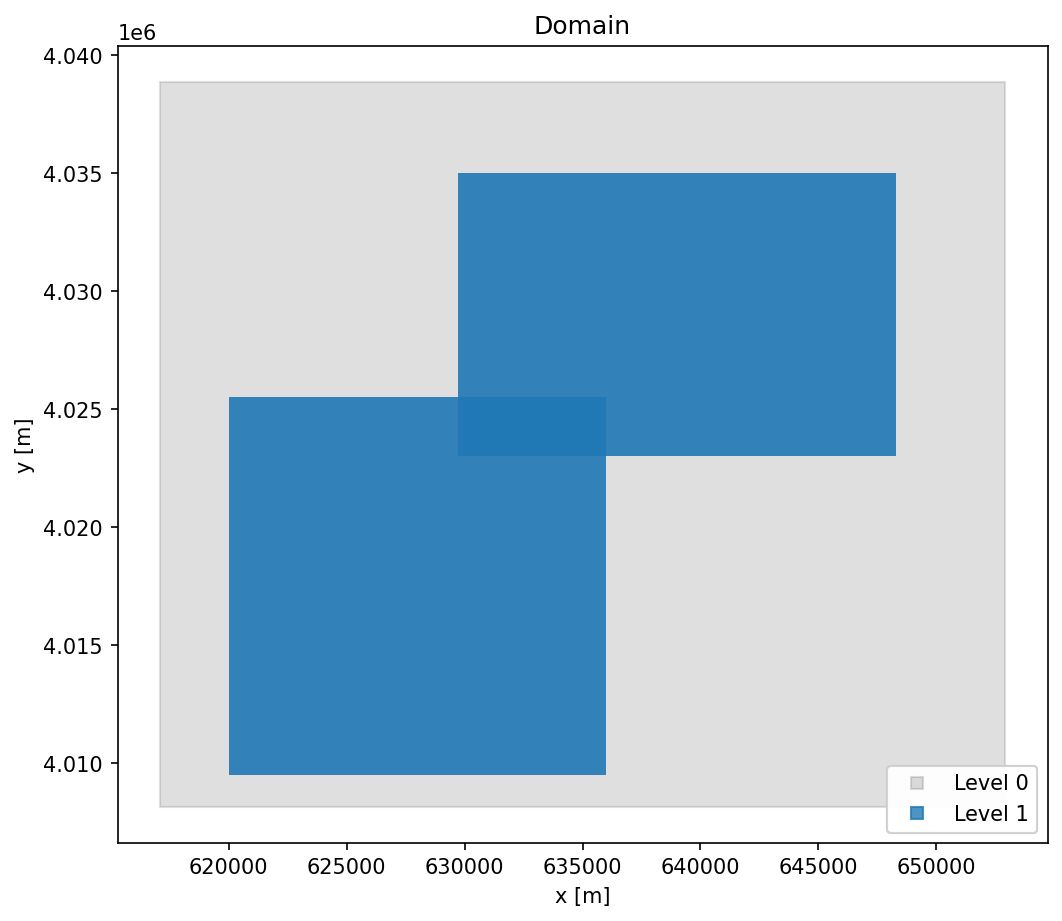

In [10]:
# Plot the domain (total domain)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = [] #case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)
ax.axis('scaled')

In [11]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0   1056964608             10.0 x 10.0 x 10.0
       1   1725120000                5.0 x 5.0 x 5.0
  TOTAL:   2782084608


In [12]:
# Write the input file
print(case.writeAMRWindInput('FarmRun1Test.inp'))

# --- Simulation time control parameters ---
time.stop_time                           = 32000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 2000                
time.checkpoint_start                    = 48000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/AWAKEN/Benchmark1/Phase1/PrecursorLayout/MMC_BM1_BigPrecursor/chk48000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model               